# Beat-finding using autocorrelations
In this snippet we learn how to do some beat-finding using autocorrelations.

First, let's import the necessary functions and classes:

In [52]:
from combio.core import Sequence
from combio.stats import acf_df, acf_plot, acf_values
import numpy as np
import scipy.signal

# We use a Generator object with a seed so you will get the same results as we:
rng = np.random.default_rng(seed=123)

## Plotting ACF
The autocorrelation function (ACF) is best represented in a plot, where on the x axis we have the autocorrelation
lags (which for us correspond to timestamps), and on the y axis we have the correlation coefficient.

We can use such a function to find an underlying inter-onset interval (IOI) that describes our sequence well.

First let's create a `Sequence` object with inter-onset intervals (IOIs) sampled from a normal distribution
(so we have some noise in there), and then plot the sequence using `combio.stats.acf_plot`.

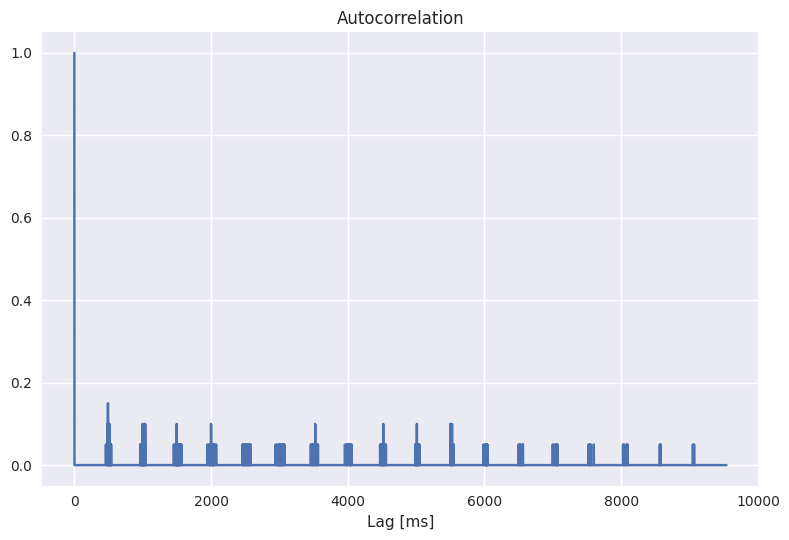

In [53]:
seq = Sequence.generate_random_normal(n=20, mu=500, sigma=25, rng=rng)
acf_plot(seq);

Now, that's a bit disappointing. We don't see any clear peaks, even though we might expect one
at the mean of the distribution (500 ms).

To improve the plot, we use the smoothing parameters, which under the hood convolve tiny normal distributions
with the acf function at each step (where the steps are of size `resolution_ms`).

So let's try that:

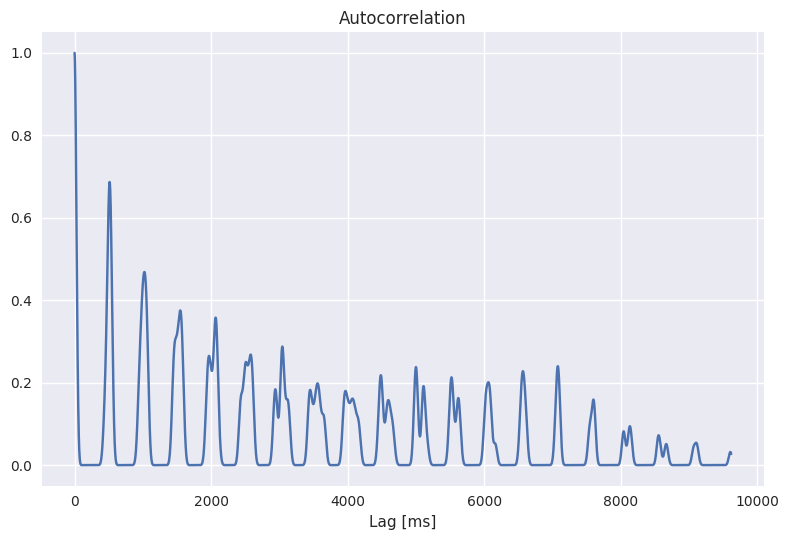

In [54]:
seq = Sequence.generate_random_normal(n=20, mu=500, sigma=25, rng=rng)
acf_plot(seq, smoothing_window=100, smoothing_sd=20);

Now that looks way better, and now we do see clear peaks at 500 ms, 1000 ms, etc.

Of course, the more we smoothe, the less accurately that IOI represents the sequence. So be careful with that, and
afterwards use e.g. the `combio.stats.get_ugof` function to calculate how well the sequence is described by the found IOI.

## Finding the IOIs
From the plot we cannot say exactly where the peaks lie. If we want to find the exact values we can use
`scipy.signal.find_peaks`

For this method, we need the actual values from the ACF function, which we can get using `combio.stats.acf_values`.
Then, we use `scipy.signal.find_peaks` to find the peaks.

In [55]:
seq = Sequence.generate_random_normal(n=20, mu=500, sigma=25, rng=rng)
correlation_factors = acf_values(seq, resolution_ms=1, smoothing_window=100, smoothing_sd=20)

peaks = scipy.signal.find_peaks(correlation_factors)
print(peaks)

(array([   1,  495,  994, 1495, 2000, 2504, 2996, 3499, 4006, 4504, 5003,
       5500, 5999, 6507, 7006, 7498, 7993, 8482, 8975, 9472]), {})


As such, we can see where the peaks lie.

---

An important thing to note is that if you use a different `resolution_ms` than 1 ms (which is however the default ),
the peaks will correspond to the indices of `acf_values`, where the indices are not in milliseconds.
Multiply the array that `acf_values` returns by `resolution_ms` to get the timestamps in milliseconds again.

Also note that `scipy.signal.find_peaks` returns a tuple
containing an array with the peak values, and a `properties` dictionary, which is empty here. To get the array
we must therefore use `peaks[0]`.

In [56]:
resolution_ms = 10

seq = Sequence.generate_random_normal(n=20, mu=500, sigma=25, rng=rng)

correlation_factors = acf_values(seq,
                                 resolution_ms=resolution_ms,
                                 smoothing_window=100,
                                 smoothing_sd=20)
peaks = scipy.signal.find_peaks(correlation_factors)
peaks = peaks[0] * resolution_ms
print(peaks)

[ 510 1010 1490 1570 2020 2100 2550 2600 3090 3600 4090 4570]


## Getting a Pandas dictionary of correlation factors
The `combio.stats` module contains an additional function, `coombio.stats.acf_df`, which returns a Pandas
DataFrame containing the timestamps and the correlation factors.


In [57]:
seq = Sequence.generate_random_normal(n=20, mu=500, sigma=25, rng=rng)

df = acf_df(seq, smoothing_window=10, smoothing_sd=2)
print(df)

      time_ms  correlation
0           0     0.931255
1           1     1.000000
2           2     0.931255
3           3     0.763098
4           4     0.548497
...       ...          ...
9545     9545     0.032629
9546     9546     0.023837
9547     9547     0.014014
9548     9548     0.006382
9549     9549     0.001945

[9550 rows x 2 columns]


Let's sort this dataframe by the correlation factor:

In [58]:
df = df.sort_values(by="correlation", ascending=False)
print(df)

      time_ms  correlation
1           1     1.000000
0           0     0.931255
2           2     0.931255
3           3     0.763098
4           4     0.548497
...       ...          ...
4173     4173     0.000000
4172     4172     0.000000
4171     4171     0.000000
4170     4170     0.000000
4775     4775     0.000000

[9550 rows x 2 columns]
